<a href="https://colab.research.google.com/github/DurdenTyler2008/University-of-AI/blob/main/18_%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D0%B0%D1%83%D0%B4%D0%B8%D0%BE_%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D0%B6%D0%B0%D0%BD%D1%80%D0%BE%D0%B2_u_lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# напишите загрузку данных и распознавание стилей музыки с помощью Dense сети.

In [83]:
from google.colab import files 

from tensorflow.keras.utils import to_categorical 
import os 
import librosa                                         # Параметризация аудио
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, StandardScaler 
import time
import IPython.display as ipd

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# т.к.весь файл не загружался, пришлось 10 папок раскидать в 5 .zip файлов и так загружать в colab 
# распаковал и все файлы и пололжил в папку /content/drive/MyDrive/Audio/genres_all

In [39]:
# !unzip -q "/content/drive/My Drive/Audio/genres_5.zip" -d /content/drive/MyDrive/Audio/ 

In [45]:
#!rm -r /content/drive/MyDrive/Audio/genres_5 # удалил ошибочный файл 

In [4]:
!ls "/content/drive/MyDrive/Audio/genres_all"

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock


In [5]:
genres = os.listdir("/content/drive/MyDrive/Audio/genres_all")
genres

['classical',
 'country',
 'disco',
 'jazz',
 'pop',
 'rock',
 'blues',
 'metal',
 'reggae',
 'hiphop']

In [11]:
path = "/content/drive/MyDrive/Audio/genres_all/jazz/jazz.00099.au"

x, sr = librosa.load(path)               # x - массив данных временного ряда аудио
                                         # sr - частота дискретизации временного ряда
print(type(x), type(sr))
print(x.shape, sr)
print(x.shape[0]/sr)

<class 'numpy.ndarray'> <class 'int'>
(661794,) 22050
30.013333333333332


In [13]:
ipd.Audio(path)   # не играет(( 

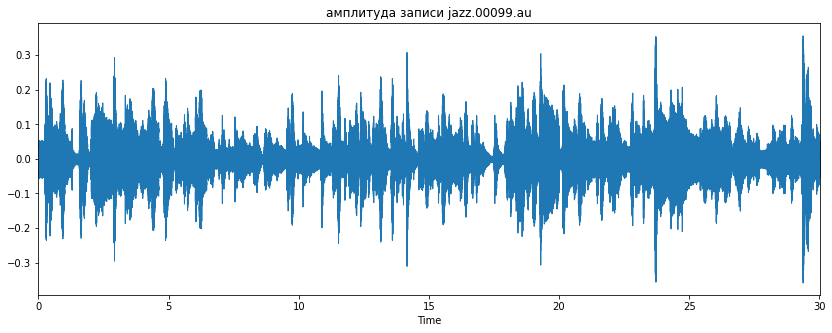

In [17]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)  # амплитуда сигнала
plt.title("амплитуда записи jazz.00099.au")
plt.show()

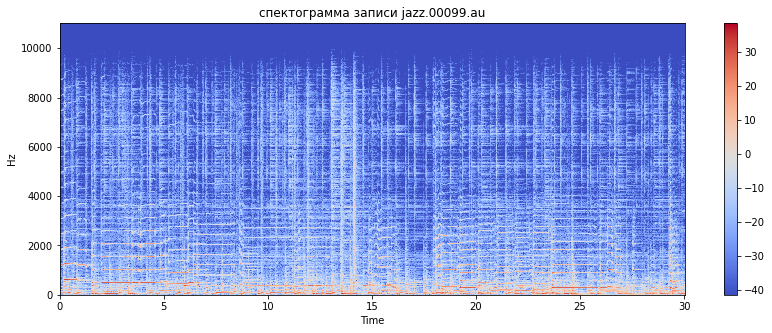

In [20]:
X = librosa.stft(x)                    # спектр сигнала
Xdb = librosa.amplitude_to_db(abs(X))  # меняю шкалу на децибелы

plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
plt.colorbar()
plt.title("спектограмма записи jazz.00099.au")
plt.show()

In [18]:
def get_features(y, sr):                                                # Функция параметризации аудио

    rmse = np.mean(librosa.feature.rms(y=y))                            # Среднеквадратичная амплитуда
    spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))  # среднее спектральныго центроида
    spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))   # среднее ширины полосы частот
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))     # среднее спектрального спада частоты
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))                # среднее частота пересечения нуля звукового временного ряда
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)               # Частота цветности (по умолчанию 12 баков цветности)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)                             # Мел кепстральные коэффициенты (по умолчанию 20) 

    out = []                                                             # все параметры кладу сюда
    out.append(rmse) 
    out.append(spec_cent) 
    out.append(spec_bw) 
    out.append(rolloff) 
    out.append(zcr) #
    
    for e in mfcc:
        out.append(np.mean(e))  
                                                                        # среднее всех Мел спектральных коэффициентов (20 значений)
    for e in chroma_stft:
        out.append(np.mean(e))                                          # среднее всех Частот цветности (12 значений)

    return out                                                          # список размерностью (37,)

In [19]:
X_train = []
Y_train = []

curr_time = time.time()                                                   # время старта формирования выборки

for i in range(len(genres)):
    g = genres[i]                                                         # Берём текущий жанр
 
    for filename in os.listdir(f"./drive/MyDrive/Audio/genres_all/{g}"):  # Проходим по файлам папки, соответствующей текущему жанру                     
      songname = f"./drive/MyDrive/Audio/genres_all/{g}/{filename}"       # Получаем имя песни
      
                                                                          # Загружаем в y аудиосигнал и берем первые 30 секунд аудио
      y, sr = librosa.load(songname, mono=True, duration=30)              # y - массив данных временного ряда аудио, sr - частота дискретизации временного ряда
      out = get_features(y, sr)                                           # сигнал в параметризованные данные

      X_train.append(out)                                                 # строку в X_train
      Y_train.append(to_categorical(i, len(genres)))                      # Y_train номер жанра в формате onecode

    #Выводим информацию о готовности обработки базы
    print("Жанр: ", g, " готов за:", round(time.time() - curr_time), "ceк")
    curr_time = time.time()

Жанр:  classical  готов за: 92 ceк
Жанр:  country  готов за: 102 ceк
Жанр:  disco  готов за: 102 ceк
Жанр:  jazz  готов за: 96 ceк
Жанр:  pop  готов за: 99 ceк
Жанр:  rock  готов за: 98 ceк
Жанр:  blues  готов за: 103 ceк
Жанр:  metal  готов за: 103 ceк
Жанр:  reggae  готов за: 101 ceк
Жанр:  hiphop  готов за: 105 ceк


In [21]:
X_train = np.array(X_train)   # обучающую выборку на numpy массивы
Y_train = np.array(Y_train)   # обучающую выборку на numpy массивы

In [22]:
X_train_backup = X_train.copy()
Y_train_backup = Y_train.copy()

In [23]:
Y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [24]:
y_train_class = np.argmax(Y_train, axis=1)
print(y_train_class)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [26]:
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

(1000, 37)
(1000, 10)
(1000,)


In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Номировка X_train
print(X_train[0])

[-1.40878536 -1.37442596 -1.68976734 -1.44634673 -0.80893346 -1.56168774
  1.96572041 -0.70660742 -0.49991926 -0.13900959 -1.03663243 -0.61580617
 -0.94724199  0.0209379  -0.2070867  -0.30972373 -0.93535491  0.1122971
 -0.76437545  0.46671696 -0.10953881  1.19204005 -0.18835471  0.27617984
 -1.56574885 -1.50514224 -2.0039899  -0.24974864 -0.19481898 -1.87266609
 -0.38627756 -1.80002412 -1.11723854 -0.77982951 -0.98262126  1.23600556
 -1.64628799]


**Разбивка базы на обучающую и проверочную базы**

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(900, 37)
(900,)
(100, 37)
(100,)


**Данные подготовленны, перехожу к созданию сетей**

In [29]:
indexes = range(0,37)                        # все параметры 
model1 = Sequential()                        

model1.add(Dense(256, activation='elu', input_shape=(len(indexes),)))
model1.add(Dense(128, activation='elu'))
model1.add(Dense(64, activation='elu'))
model1.add(Dense(32, activation='elu'))

model1.add(Dense(len(genres), activation='softmax'))


In [30]:
model1.compile(optimizer=RMSprop(lr=1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [31]:
history = model1.fit(X_train[:, indexes],y_train,epochs=200,batch_size=20,validation_data=(X_test[:, indexes], y_test),verbose=0 )
print("cредняя абсолютная ошибка на обучающем наборе:", round(history.history["accuracy"][199], 3))
print("cредняя абсолютная ошибка на проверочном наборе:", round(history.history["val_accuracy"][199], 3))

cредняя абсолютная ошибка на обучающем наборе: 0.998
cредняя абсолютная ошибка на проверочном наборе: 0.57


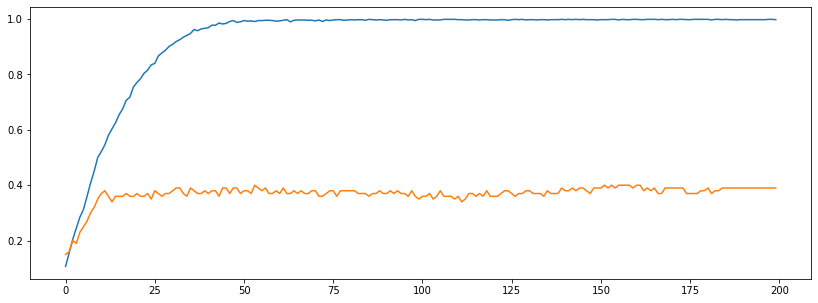

In [67]:
plt.figure(figsize=(14, 5))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

**это сеть с только Мел коэффициэнтами**

In [33]:
indexes = range(5,25)
model2 = Sequential()                        

model2.add(Dense(256, activation='elu', input_shape=(len(indexes),)))
model2.add(Dense(128, activation='elu'))
model2.add(Dense(64, activation='elu'))
model2.add(Dense(32, activation='elu'))

model2.add(Dense(len(genres), activation='softmax'))


In [34]:
model2.compile(optimizer=RMSprop(lr=1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [35]:
history = model2.fit(X_train[:, indexes],y_train,epochs=200,batch_size=20,validation_data=(X_test[:, indexes], y_test),verbose=0 )
print("cредняя абсолютная ошибка на обучающем наборе:", round(history.history["accuracy"][199], 3))
print("cредняя абсолютная ошибка на проверочном наборе:", round(history.history["val_accuracy"][199], 3))

cредняя абсолютная ошибка на обучающем наборе: 0.914
cредняя абсолютная ошибка на проверочном наборе: 0.56


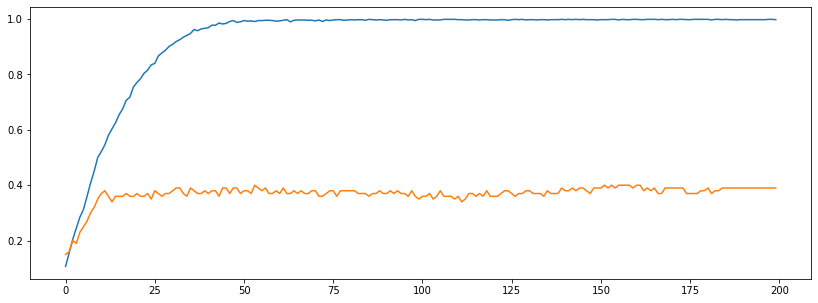

In [68]:
plt.figure(figsize=(14, 5))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

**это сеть, гда Мел спектральные коэффициенты + частоты цветности**

In [39]:
indexes = range(5,37)
model3 = Sequential()                        

model3.add(Dense(256, activation='elu', input_shape=(len(indexes),)))
model3.add(Dense(128, activation='elu'))
model3.add(Dense(64, activation='elu'))
model3.add(Dense(32, activation='elu'))

model3.add(Dense(len(genres), activation='softmax'))


In [41]:
model3.compile(optimizer=RMSprop(lr=1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [42]:
history = model3.fit(X_train[:, indexes],y_train,epochs=200,batch_size=20,validation_data=(X_test[:, indexes], y_test),verbose=0 )
print("cредняя абсолютная ошибка на обучающем наборе:", round(history.history["accuracy"][199], 3))
print("cредняя абсолютная ошибка на проверочном наборе:", round(history.history["val_accuracy"][199], 3))

cредняя абсолютная ошибка на обучающем наборе: 0.994
cредняя абсолютная ошибка на проверочном наборе: 0.61


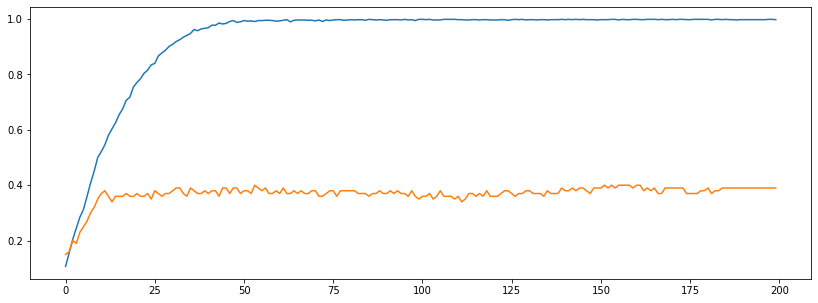

In [69]:
plt.figure(figsize=(14, 5))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

**это сеть, где все параметры (0-37) с шагом 2**

In [44]:
indexes = range(0,37,2)
model4 = Sequential()                        

model4.add(Dense(256, activation='elu', input_shape=(len(indexes),)))
model4.add(Dense(128, activation='elu'))
model4.add(Dense(64, activation='elu'))
model4.add(Dense(32, activation='elu'))

model4.add(Dense(len(genres), activation='softmax'))

In [45]:
model4.compile(optimizer=RMSprop(lr=1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [46]:
history = model4.fit(X_train[:, indexes],y_train,epochs=200,batch_size=20,validation_data=(X_test[:, indexes], y_test),verbose=0 )
print("cредняя абсолютная ошибка на обучающем наборе:", round(history.history["accuracy"][199], 3))
print("cредняя абсолютная ошибка на проверочном наборе:", round(history.history["val_accuracy"][199], 3))

cредняя абсолютная ошибка на обучающем наборе: 0.922
cредняя абсолютная ошибка на проверочном наборе: 0.57


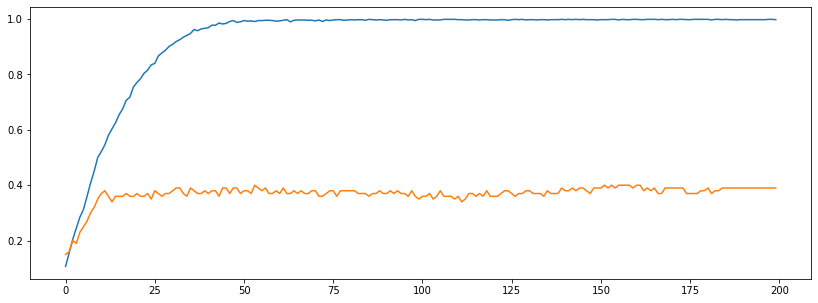

In [70]:
plt.figure(figsize=(14, 5))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Расширяю выборки, для этого преобразую(имеющиеся данные в квадрате,в квадрате из абсол.значений,обр.значение,2 в степени t) и полученные векторы добавляю в обучающую и проверочную выборки                      
т.е.это искусственное расширение выборок 

In [50]:
X_train_sqr = np.array([[t**2 for t in x] for x in X_train])          # вектор квадратных значений
X_test_sqr = np.array([[t**2 for t in x] for x in X_test])

In [51]:
X_train_sqrt = np.array([[abs(t)**0.5 for t in x] for x in X_train])  # вектор квадр.корней из абсолютн.значений
X_test_sqrt = np.array([[abs(t)**0.5 for t in x] for x in X_test])

In [52]:
X_train_inv = np.array([[t**(-1) for t in x] for x in X_train])       # вектор обратн.значений
X_test_inv = np.array([[t**(-1) for t in x] for x in X_test])

In [53]:
X_train_exp = np.array([[2**t for t in x] for x in X_train])          # вектор 2 в степени значений
X_test_exp = np.array([[2**t for t in x] for x in X_test])

In [61]:
X_train_2 = np.hstack([X_train, X_train_sqr, X_train_sqrt, X_train_inv, X_train_exp])  # объединяю в один массив
X_test_2 = np.hstack([X_test, X_test_sqr, X_test_sqrt, X_test_inv, X_test_exp])

print(X_train_2.shape)      #  5 векторов по 37 значений = 185
print(X_test_2.shape)

(900, 185)
(100, 185)


In [56]:
print(X_train_2[2])           # проверяю 

[ 1.32015905  1.08763981  0.10419631  0.56547527  2.1616833   1.54223128
 -0.81218917 -1.07523062  1.58988536 -1.81554625  1.30137081 -0.98103281
  0.95979656 -0.62200806  1.44336943 -1.31452022  2.13516278 -1.21296107
  1.89827726 -1.15203354  1.48108608 -0.36220447  1.07249564 -0.78765527
  2.06570894  1.2887196   2.17063707  1.0135708   0.45685503  1.34387851
  0.45527924  0.51762127  1.18097901  1.97768854  2.22266236  1.21318181
  1.15115313  1.74281991  1.18296035  0.01085687  0.31976228  4.67287471
  2.37847732  0.65965125  1.15612088  2.52773545  3.29620817  1.693566
  0.96242537  0.92120944  0.38689403  2.08331531  1.72796341  4.55892011
  1.47127455  3.60345655  1.32718127  2.19361598  0.13119208  1.1502469
  0.62040082  4.26715341  1.66079821  4.71166531  1.02732577  0.20871652
  1.80600946  0.20727919  0.26793178  1.39471143  3.91125195  4.94022797
  1.47181011  1.32515352  1.14898174  1.04289971  0.32279453  0.7519809
  1.47026641  1.24186605  0.90121539  1.03693328  1.260

**Это сеть на расширенной выборке**

In [62]:
indexes = range(0,37)
model5 = Sequential()                        

model5.add(Dense(256, activation='elu', input_shape=(X_train_2.shape[1],)))
model5.add(Dense(128, activation='elu'))
model5.add(Dense(64, activation='elu'))
model5.add(Dense(32, activation='elu'))

model5.add(Dense(len(genres), activation='softmax'))

In [63]:
model5.compile(optimizer=RMSprop(lr=1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [65]:
history = model5.fit(X_train_2, y_train, epochs=200, batch_size=20, validation_data=(X_test_2, y_test),verbose=0 )
print("cредняя абсолютная ошибка на обучающем наборе:", round(history.history["accuracy"][199], 3))
print("cредняя абсолютная ошибка на проверочном наборе:", round(history.history["val_accuracy"][199], 3))

cредняя абсолютная ошибка на обучающем наборе: 0.998
cредняя абсолютная ошибка на проверочном наборе: 0.39


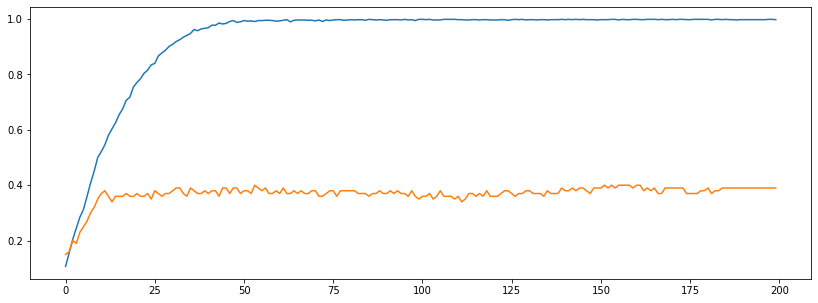

In [71]:
plt.figure(figsize=(14, 5))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

**functional API model6**

In [72]:
input1 = Input((37,)) 

x1 = Dense(128, activation="elu")(input1) 
x1 = Dense(64, activation="elu")(x1)
x1 = Dense(32, activation="elu")(x1)

x2 = Dense(32, activation="elu")(input1)
x2 = Dense(64, activation="elu")(x2)
x2 = Dense(128, activation="softmax")(x2)

x = concatenate([x1, x2])

x = Dense(10, activation='elu')(x)
x = Dense(10, activation='softmax')(x)

model6 = Model(input1, x)

In [74]:
model6.compile(optimizer=Adam(lr=1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [76]:
history = model6.fit(X_train, y_train, epochs=600, batch_size=20, validation_data=(X_test, y_test), verbose=0)
print("cредняя абсолютная ошибка на обучающем наборе:", round(history.history["accuracy"][199], 3))
print("cредняя абсолютная ошибка на проверочном наборе:", round(history.history["val_accuracy"][199], 3))

cредняя абсолютная ошибка на обучающем наборе: 0.93
cредняя абсолютная ошибка на проверочном наборе: 0.53


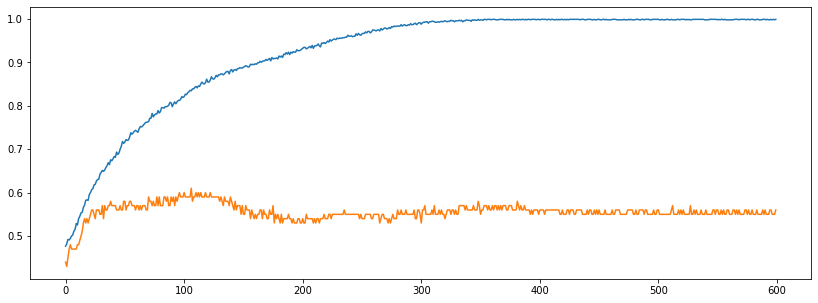

In [77]:
plt.figure(figsize=(14, 5))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

**functional API model7**

In [78]:
indexes = range(0,37)
input1 = Input((len(indexes),))

x1 = Dense(256, activation="elu")(input1)
x1 = BatchNormalization()(x1)
x1 = Dense(256, activation="elu")(x1)
x1 = BatchNormalization()(x1)

x2 = Dense(256, activation="elu")(input1)
x2 = BatchNormalization()(x2)
x2 = Dense(40, activation="softmax")(x2)
x2 = BatchNormalization()(x2)

x3 = Dense(256, activation="elu")(input1)
x3 = BatchNormalization()(x3)
x3 = Dense(200, activation="softmax")(x3)
x3 = BatchNormalization()(x3)

x4 = Dense(40, activation="softmax")(input1)
x4 = BatchNormalization()(x4)

x5 = Dense(200, activation="softmax")(input1)
x5 = BatchNormalization()(x5)

x6 = Dense(10, activation="softmax")(input1)
x6 = BatchNormalization()(x6)

x7 = Dense(256, activation="elu")(input1)
x7 = BatchNormalization()(x7)
x7 = Dense(10, activation="softmax")(x7)
x7 = BatchNormalization()(x7)

x = concatenate([x1, x2, x3, x4, x5, x6, x7])

x = BatchNormalization()(x)
x = Dense(256, activation='elu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation='softmax')(x)

model7 = Model(input1, x)

In [80]:
model7.compile(optimizer=RMSprop(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [81]:
history = model7.fit(X_train[:, indexes], y_train, epochs=400, batch_size=20, validation_data=(X_test[:, indexes], y_test), verbose=0)
print("cредняя абсолютная ошибка на обучающем наборе:", round(history.history["accuracy"][399], 3))
print("cредняя абсолютная ошибка на проверочном наборе:", round(history.history["val_accuracy"][399], 3))


cредняя абсолютная ошибка на обучающем наборе: 0.997
cредняя абсолютная ошибка на проверочном наборе: 0.67


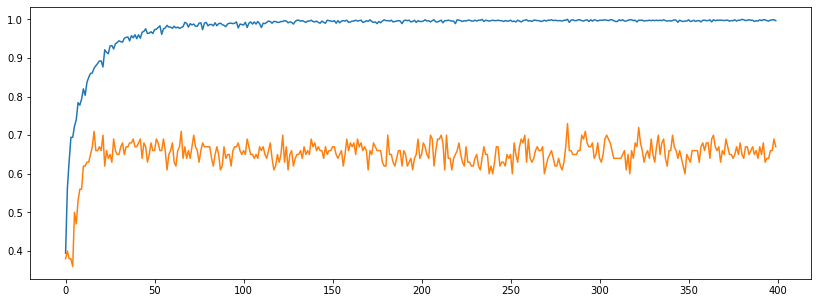

In [82]:
plt.figure(figsize=(14,5))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

**РЕЗУЛЬТАТЫ**

In [87]:
dict_models = {"model1":[0.998, 0.57], "model2":[0.914, 0.56], "model3":[0.994, 0.61],
               "model4":[0.922, 0.61], "model5":[0.998, 0.39], "model6":[0.998, 0.39], "model7":[0.99, 0.67]}
df = pd.DataFrame.from_dict(dict_models)
df.index = ["accuracy", "val_accuracy"]
df

,model1,model2,model3,model4,model5,model6,model7
accuracy,0.998,0.914,0.994,0.922,0.998,0.998,0.99
val_accuracy,0.570,0.560,0.610,0.610,0.390,0.390,0.67


**Распознование класса песен**


In [101]:
print("классы:", genres)

классы: ['classical', 'country', 'disco', 'jazz', 'pop', 'rock', 'blues', 'metal', 'reggae', 'hiphop']


In [102]:
songname = "./drive/MyDrive/Audio/genres_all/jazz/jazz.00002.au"

y, sr = librosa.load(songname, mono=True, duration=30)  # аудиосигнал длинны 30 сек
out = get_features(y, sr)                               # параметризация

In [103]:
out = np.array(out).reshape(1,37)                       # + одна размерность, этого требует model.predict
out.shape

(1, 37)

In [104]:
out = scaler.transform(out)   # преобразование c помощью scaler, обученного на обучающей выборке 

In [106]:
y = model7.predict(out)

In [111]:
print("выход с softmax: \n", y)
answer = np.argmax(y)
question = genres.index("jazz")

if answer == question:
    print("ответ сети:", answer, "-это верный ответ")
else:
  print("ответ сети:", answer, "-это не верный ответ", "верный ответ", question)

выход с softmax: 
 [[7.1334032e-09 1.0715219e-06 1.1188852e-10 9.9999881e-01 2.1367917e-10
  8.4445638e-11 7.6144438e-08 2.5651981e-09 1.4212389e-11 5.6711267e-09]]
ответ сети: 3 -это верный ответ
